In [1]:
import numpy as np
from scipy.stats import norm
#from tabulate import tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.dates as mdates
import statsmodels.api as sm
from sympy.solvers import solve
from sympy import Symbol
warnings.filterwarnings('ignore')

In [2]:
#Read Data
data = pd.read_csv(r'Data/ToF_2021_PS5-data-1.csv', delimiter = ';', index_col = 'date')
print(data.head(n = 10))

            UBS_CHINA_EQUITY_FUND
date                             
10.08.2018                  17862
13.08.2018                  17784
14.08.2018                  17552
15.08.2018                  17424
16.08.2018                  17015
17.08.2018                  16797
20.08.2018                  16640
21.08.2018                  16840
22.08.2018                  17088
23.08.2018                  17247


In [3]:
#Problem 2

S = 12361.69
sigma = 0.1331
rf = -0.0076
m = 1/12

In [4]:
# a
# See solution sheet

In [5]:
# b
Kc = call_strike = 12600
Kp = put_strike = 12100

# Formula for European Call Option (21.3)

#Call_price = S*phi(d1)-(e^(-ym))*Kc*phi(d2)
#Put_price = Kp*e^(-ym)*phi(-d2)-S*phi(-d1)
#S = Spot
#y = risk free
#m = time to maturity
#K = Strike Price
#sigma = volatility of asset

#Call Price
d1_call = (np.log(S/Kc)+(rf+(sigma**2)/2.)*m)/(sigma*np.sqrt(m))
d2_call = d1_call-sigma*np.sqrt(m)

bs_call_price = S*norm.cdf(d1_call)-Kc*np.exp(-rf*m)*norm.cdf(d2_call)

#Put Price
d1_put = (np.log(S/Kp)+(rf+(sigma**2)/2.)*m)/(sigma*np.sqrt(m))
d2_put = d1_put-sigma*np.sqrt(m)

# bs_put_price = Kp*np.exp(-rf*m)-S+bs_call_price
bs_put_price = Kp*np.exp(-rf*m)*norm.cdf(-d2_put)-S*norm.cdf(-d1_put)

print("The option price for a European Call, with Strike 12'600, is: " + str(round(bs_call_price, 2)))
print("The option price for a European Put, with Strike 12'100, is: " + str(round(bs_put_price, 2)))

The option price for a European Call, with Strike 12'600, is: 92.89
The option price for a European Put, with Strike 12'100, is: 87.24


In [13]:
# c
#The Greeks (Formula found at Remark 22.5)
#Delta
delta_call = norm.cdf(d1_call)
dcall = round((delta_call), 2)
delta_put = -norm.cdf(d1_put)
dput = round((delta_put), 2)
#Gamma
gamma_call = norm.pdf(d1_call) / (S*sigma*np.sqrt(m))
gcall = round((gamma_call), 2)
gamma_put = gamma_call
gput = round((gamma_put), 2)
#Theta
theta_call = 0.01*(-(S*norm.pdf(d1_call)*sigma)/(2*np.sqrt(m)) - rf*Kc*np.exp(-rf*m)*norm.cdf(d2_call))
tcall = round((theta_call), 2)
theta_put = 0.01*(-(S*norm.pdf(d1_put)*sigma)/(2*np.sqrt(m)) + rf*Kp*np.exp(-rf*m)*norm.cdf(-d2_put))
tput = round((theta_put), 2)
#Rho
rho_call = 0.01*(Kc*m*np.exp(-rf*m)*norm.cdf(d2_call))
rcall = round((rho_call), 2)
rho_put = 0.01*(-Kp*m*np.exp(-rf*m)*norm.cdf(-d2_put))
rput = round((rho_put), 2)
#Vega
vega_call = 0.01*(S*norm.pdf(d1_call)*np.sqrt(m))
vcall = round((vega_call), 2)
vega_put = 0.01*(S*norm.pdf(d1_put)*np.sqrt(m))
vput = round((vega_put), 2)

table = [['Greeks', 'Call', 'Put'], ['Delta', dcall, dput], ['Gamma', gcall, dput], ['Theta', tcall, tput], ['Rho', rcall, rput], ['Vega', vcall, vput]]

#print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', numalign="right"))

NameError: name 'tabulate' is not defined

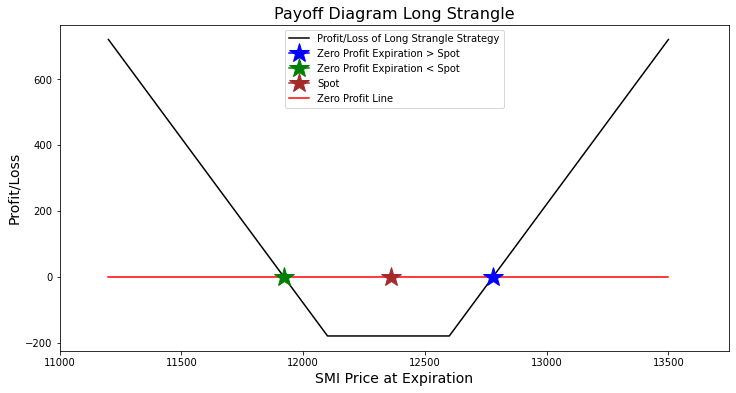

In [7]:
# d
expiration = np.arange(11200, 13600, 100)[::-1]

call_profit = []
for i in expiration:
    if Kc <= i:
        j = i-Kc-bs_call_price
    else: j = -bs_call_price
    call_profit.append(j)

put_profit = []
for i in expiration:
    if Kp <= i:
        j = -bs_put_price
    else: j = Kp-i-bs_put_price
    put_profit.append(j)


profits = pd.DataFrame(columns = ['Profit/Loss Call', 'Profit/Loss Put', 'Profit Long Strangle'],  index = expiration)
profits['Profit/Loss Call'] = call_profit
profits['Profit/Loss Put'] = put_profit
profits['Profit Long Strangle'] = profits['Profit/Loss Call'] + profits['Profit/Loss Put']
profits['Zero'] = [0]*24



plt.figure(figsize = (12,6))
plt.plot(expiration, profits['Profit Long Strangle'], color ='black', label ='Profit/Loss of Long Strangle Strategy', zorder=1)
plt.plot(12780.13, 0, color = 'blue', marker='*', label = 'Zero Profit Expiration > Spot', markersize=20.0, zorder=3)
plt.plot(11919.87, 0, color = 'Green', marker='*', label = 'Zero Profit Expiration < Spot', markersize=20.0, zorder=4)
plt.plot(S,0, color='brown', marker='*', label = 'Spot', markersize=20.0, zorder=5)
plt.plot(expiration, profits['Zero'], color='red', linestyle='-', label='Zero Profit Line', zorder=2)
plt.xlim(xmin=11000, xmax=13750)
plt.legend(loc='best')


plt.title('Payoff Diagram Long Strangle', size = 16)
plt.xlabel('SMI Price at Expiration', size = 14)
plt.ylabel('Profit/Loss', size = 14)

plt.show()


### e)

In [8]:
# The phi(d2) term in the Black- Scholes formula (21.3)–(21.4) is the risk-neutral probability that S_m > K
# calculating the risk-neutral probability that we will make a profit with this strategy:
rn_d1_call = (np.log((S+bs_call_price)/Kc)+(rf+(sigma**2)/2.)*m)/(sigma*np.sqrt(m))
rn_d2_call = rn_d1_call-sigma*np.sqrt(m)

rn_probability_call = norm.cdf(rn_d2_call)
rn_probability_call

rn_d1_put = (np.log((S+bs_put_price)/Kp)+(rf+(sigma**2)/2.)*m)/(sigma*np.sqrt(m))
rn_d2_put = d1_put-sigma*np.sqrt(m)

rn_probability_put = norm.cdf(-rn_d2_put)
rn_probability_put

print("The risk-neutral probaility that this strategy will generate a profit is: " + str(round(rn_probability_call+rn_probability_put, 2)))

The risk-neutral probaility that this strategy will generate a profit is: 0.67


### f)

In [9]:
# the Value of the portfolio is
# V = vS + M - L
# we assume M = 0 and L = - 1C - 1P given we're long one of each
# becomes V = vS + 1C + 1P 
# given we're looking to be delta neutral need to take the deriv of this wrt S
# so we have v = phi(d1_call) - phi(d1_put)
# copied from cyril above: 
#delta_call = norm.cdf(d1_call)
#dcall = round((delta_call), 2)
#delta_put = -norm.cdf(d1_put)

v = - delta_call - delta_put
print(str(round(v, 4))+" units of the underlying need to be bought such that the position is delta-neutral")


0.4016 units of the underlying need to be bought such that the position is delta-neutral


### g)

In [10]:
# we want to have a 70% risk neutral probability that at least one of the options is in the money
# given both options contribute equally we want: phi(d2_put) =0.35 and 1-phi(d2_call) =0.35
# corresponding values of the normal distribution are -0.385 and 0.385
#defining d2
d2_p = 0.385
d2_c = -0.385
#solve formula 21.4 now back to get K
# K = S/exp((d2+sigma*sqrt(m))*sigma*sqrt(m) - (y+sigma**2/2)*m)


In [11]:
S = 12361.69
sigma = 0.1331
y = -0.0076
m = 1/12

Kp_g = S/np.exp((d2_p+sigma*np.sqrt(m))*sigma*np.sqrt(m) - (y+sigma**2/2)*m)
Kc_g = S/np.exp((d2_c+sigma*np.sqrt(m))*sigma*np.sqrt(m) - (y+sigma**2/2)*m)

print("The strike for the call option needs to be set at " + str(round(Kc_g, 2)))
print("The strike for the put option needs to be set at " + str(round(Kp_g, 2)))


The strike for the call option needs to be set at 12528.72
The strike for the put option needs to be set at 12163.48


### h)

In [12]:
#Call Price
d1_call = (np.log(S/Kc_g)+(rf+(sigma**2)/2.)*m)/(sigma*np.sqrt(m))
d2_call = d1_call-sigma*np.sqrt(m)

call_price = S*norm.cdf(d1_call)-Kc_g*np.exp(-rf*m)*norm.cdf(d2_call)

#Put Price
d1_put = (np.log(S/Kp_g)+(rf+(sigma**2)/2.)*m)/(sigma*np.sqrt(m))
d2_put = d1_put-sigma*np.sqrt(m)

put_price = Kp_g*np.exp(-rf*m)*norm.cdf(-d2_put)-S*norm.cdf(-d1_put)

print("The option price for a European Call, with Strike 12528.72, is: " + str(round(call_price, 2)))
print("The option price for a European Put, with Strike 12163.48, is: " + str(round(put_price, 2)))

#calculating the strategy value is
# V = - (-1C - 1P)

V = call_price + put_price
print("The overall strategy value is : " + str(round(V, 2)))

The option price for a European Call, with Strike 12528.72, is: 115.96
The option price for a European Put, with Strike 12163.48, is: 107.91
The overall strategy value is : 223.87
